In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
"""

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank_iter, eprank_non_iter
from tqdm import tqdm
import pandas as pd
from scipy.stats import norm
from cw2 import sorted_barplot
import scipy



We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

In [3]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)


100%|██████████| 1100/1100 [01:07<00:00, 16.23it/s]


Plot selected players

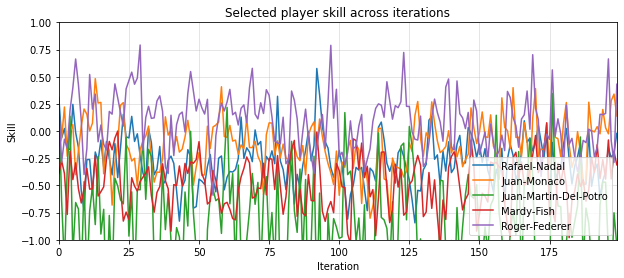

In [4]:
no_to_show = 5
fig, ax = plt.subplots(1, figsize=(10, 4))

players_to_show = np.random.choice(M, size=no_to_show, replace=False)
steps_to_show = 200
for i in range(no_to_show):
    ax.plot(
        np.arange(steps_to_show),
        skill_samples[players_to_show[i], :steps_to_show].T,
        label=W[i, 0],
    )
    ax.set_xlim(0, steps_to_show - 1)
    ax.grid(alpha=0.4)
plt.xlabel("Iteration")
plt.ylabel("Skill")
plt.ylim((-1, 1))
plt.title("Selected player skill across iterations")
plt.legend(loc="lower right")
plt.savefig("plots/Ta_sample_skills.png", format="png", dpi=500, bbox_inches="tight")

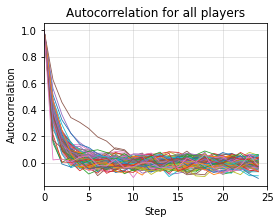

In [5]:
# autocorrelation function for players

steps = 25
autocor = np.zeros(steps)
plt.subplots(1, figsize = (4,3))
for p in range(M):
    for i in range(steps):
        autocor[i] = pd.Series.autocorr(pd.Series(skill_samples[p, :]), lag=i)
    plt.plot(autocor, linewidth=0.8)
plt.xlim(0,steps)
plt.xlabel("Step")
plt.ylabel("Autocorrelation")
plt.title(f"Autocorrelation for all players")
plt.grid(alpha = 0.4)
plt.savefig('plots/Ta_acorr.png', format="png", dpi=500, bbox_inches="tight")

# EP ranking

In [6]:
num_iters = 400
# from eprank import eprank, eprank_iter
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank_non_iter(
    G, M, num_iters
)  # final skills after iteration
# print(len(mean_player_skills))

In [7]:
mean_skills = np.zeros((num_iters, M))
precision_skills = np.zeros((num_iters, M))
for i, (mean, precision) in tqdm(enumerate(eprank_iter(G, M, num_iters))):
    mean_skills[i] = mean
    precision_skills[i] = precision
std_dev = np.true_divide(i, precision_player_skills)

mean_player_skills = mean_skills[-1]
precision_player_skills = precision_skills[-1]
# print((mean_skills[1:] - mean_skills[:-1])[:50].shape)

400it [00:03, 118.34it/s]


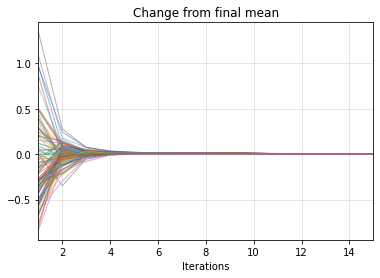

In [8]:
show_n_iter = 15
plt.figure(figsize=(6, 4))
plt.plot(
    np.arange(1, show_n_iter + 1),
    (mean_skills[1:] - mean_skills[:-1])[:show_n_iter],
    alpha=0.5,
    linewidth=1.0,
)

plt.xlim(1, show_n_iter)
plt.title("Change from final mean")
plt.xlabel("Iterations")
plt.ylabel("")
plt.grid(alpha=0.4)
plt.savefig(
    "plots/change_in_mean_normal.png", format="png", dpi=500, bbox_inches="tight"
)

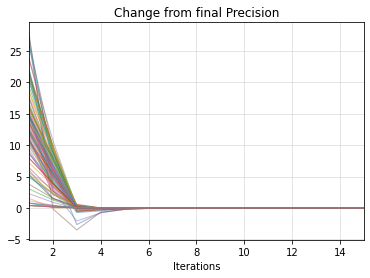

In [9]:
show_n_iter = 15
plt.figure(figsize=(6, 4))
plt.plot(
    np.arange(1, show_n_iter + 1),
    (precision_skills[1:] - precision_skills[:-1])[:show_n_iter],
    alpha=0.5,
    linewidth=1.0,
)

plt.xlim(1, show_n_iter)
plt.title("Change from final Precision")
plt.xlabel("Iterations")
plt.ylabel("")
plt.grid(alpha=0.4)
plt.savefig(
    "plots/change_in_precision_normal.png", format="png", dpi=500, bbox_inches="tight"
)

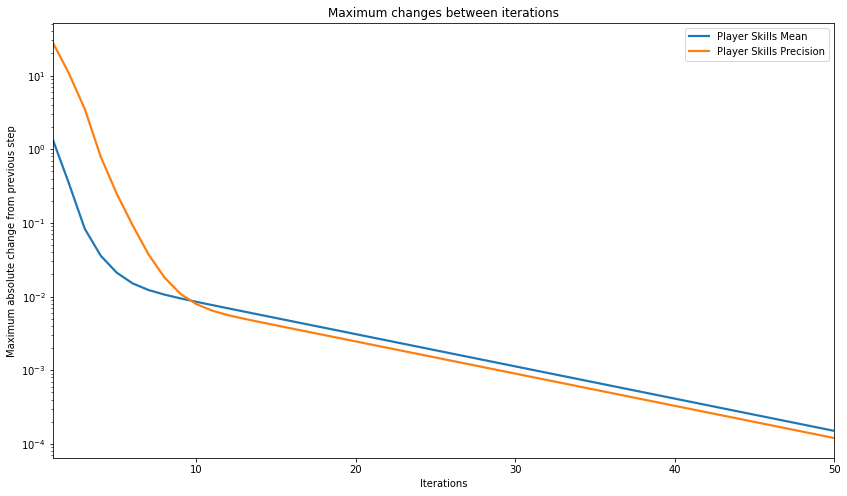

In [10]:
# Maximum change in mean and precision
show_n_iter = 50
plt.figure(figsize=(14, 8))

max_mean_change = np.max(np.abs(mean_skills[1:] - mean_skills[:-1]), axis=1)
max_prec_change = np.max(np.abs(precision_skills[1:] - precision_skills[:-1]), axis=1)

plt.plot(
    np.arange(1, show_n_iter + 1),
    max_mean_change[:show_n_iter],
    label="Player Skills Mean",
    linewidth=2.2,
)
plt.plot(
    np.arange(1, show_n_iter + 1),
    max_prec_change[:show_n_iter],
    label="Player Skills Precision",
    linewidth=2.2,
)
plt.yscale("log")
plt.xlim(1, show_n_iter)
plt.xlabel("Iterations")
plt.ylabel("Maximum absolute change from previous step")
plt.legend()
plt.title("Maximum changes between iterations")
plt.savefig('plots/max_change_in_mean_and_precision.png', format='png', dpi=500, bbox_inches='tight')

In [11]:
# Get top 4 players (by ATP) player IDs
top_4_atp = ["Novak-Djokovic", "Rafael-Nadal", "Roger-Federer", "Andy-Murray"]
top_4_atp_ids = []
for name in top_4_atp:
    top_4_atp_ids.append(int(np.argwhere(W[:, 0] == name)))
print(top_4_atp_ids)
top_4_atp_ids = np.array(top_4_atp_ids)

djok_nadal = ["Novak-Djokovic", "Rafael-Nadal"]
djok_nadal_ids = []
for name in djok_nadal:
    djok_nadal_ids.append(int(np.argwhere(W[:, 0] == name)))
print(djok_nadal_ids)
djok_nadal_ids = np.array(djok_nadal_ids)

[15, 0, 4, 10]
[15, 0]


In [12]:
top_4_means = mean_player_skills[top_4_atp_ids]
top_4_vars = precision_player_skills[top_4_atp_ids] ** (-1)

djok_nadal_means = mean_player_skills[top_4_atp_ids]
djok_nadal_vars = precision_player_skills[top_4_atp_ids] ** (-1)

In [13]:
mean_differences = top_4_means[:, None] - top_4_means[None, :]
vars_sums = top_4_vars[:, None] + top_4_vars[None, :]

In [14]:
prob_has_better_skill = 1.0 - norm.cdf(0, mean_differences, vars_sums**0.5)
print(prob_has_better_skill)

[[0.5        0.93982214 0.90888525 0.9853215 ]
 [0.06017786 0.5        0.42717033 0.76651864]
 [0.09111475 0.57282967 0.5        0.81083534]
 [0.0146785  0.23348136 0.18916466 0.5       ]]


In [15]:
prob_win = 1.0 - norm.cdf(0, mean_differences, (vars_sums + 1.0) ** 0.5)
print(prob_win)

[[0.5        0.65536701 0.63802696 0.71982573]
 [0.34463299 0.5        0.48164814 0.57311   ]
 [0.36197304 0.51835186 0.5        0.59087907]
 [0.28017427 0.42689    0.40912093 0.5       ]]


In [59]:
def numpy_to_latex(arr: np.ndarray, row_titles, col_titles) -> str:
    res = ""
    res += " & "+" & ".join(col_titles) + " \\\\ \midrule \n"
    for i in range(arr.shape[0]):
        res += f"{row_titles[i]} & "
        for j in range(arr.shape[1]):
            res += f"{arr[i, j]:.4f}"
            if j !=arr.shape[1]-1:
                res +=   " & "
        res += "\\\\ \n"
    return res


print(numpy_to_latex(prob_has_better_skill, top_4_atp, top_4_atp))
print(numpy_to_latex(prob_win, top_4_atp, top_4_atp))

 & Novak-Djokovic & Rafael-Nadal & Roger-Federer & Andy-Murray \\ \midrule 
Novak-Djokovic & 0.5000 & 0.9398 & 0.9089 & 0.9853\\ 
Rafael-Nadal & 0.0602 & 0.5000 & 0.4272 & 0.7665\\ 
Roger-Federer & 0.0911 & 0.5728 & 0.5000 & 0.8108\\ 
Andy-Murray & 0.0147 & 0.2335 & 0.1892 & 0.5000\\ 

 & Novak-Djokovic & Rafael-Nadal & Roger-Federer & Andy-Murray \\ \midrule 
Novak-Djokovic & 0.5000 & 0.6554 & 0.6380 & 0.7198\\ 
Rafael-Nadal & 0.3446 & 0.5000 & 0.4816 & 0.5731\\ 
Roger-Federer & 0.3620 & 0.5184 & 0.5000 & 0.5909\\ 
Andy-Murray & 0.2802 & 0.4269 & 0.4091 & 0.5000\\ 



# TASK D

In [17]:
skill_samples_burned_in = skill_samples[:, 10:]
print(skill_samples_burned_in.shape)

(107, 1090)


In [18]:
skill_samples_burned_in = skill_samples[:, 10:]
print(skill_samples_burned_in.shape)

(107, 1090)


In [19]:
skill_samples_df = pd.DataFrame(
    {W[i, 0]: skill_samples_burned_in[i] for i in range(W.shape[0])}
)

In [20]:
# import seaborn as sns

# sns.set(rc={"figure.figsize": (14, 8.27)})

# with sns.axes_style("white"):
#     sns.jointplot(
#         x="Novak-Djokovic", y="Rafael-Nadal", data=skill_samples_df, color="k"
#     )
# plt.xlabel("Djokovic Skill")
# plt.ylabel("Nadal Skill")
# # plt.savefig('plots/djokovic-vs-nadal-gibbs-samples.eps', format='eps', dpi=200, bbox_inches='tight')

In [21]:
# with sns.axes_style("darkgrid"):
#     g = sns.PairGrid(skill_samples_df[djok_nadal], palette="pastel")
#     g.map_diag(plt.hist, linewidth=3, histtype="stepfilled", color="black")
#     g.map_offdiag(sns.kdeplot, n_levels=7)
# #     g.map_offdiag(plt.scatter, marker='+', alpha=0.5, color=sns.color_palette('pastel', 2)[0]);
# # plt.savefig(
# #     "plots/pair-grid-top4-atp-gibbs-samples.eps",
# #     format="eps",
# #     dpi=200,
# #     bbox_inches="tight",
# # )

In [22]:
djokovic = 15
nadal = 0

top_four = [15, 10]

burn_in = 10
num_iters = 1100

indices = np.array(range(burn_in, num_iters))

djokovic_samples = skill_samples[djokovic, indices]
nadal_samples = skill_samples[nadal, indices]

['Novak-Djokovic'] has mu=1.9050606005227544, sigma=0.21760466017226612
['Rafael-Nadal'] has mu=1.4536931508058337, sigma=0.19136040274320582


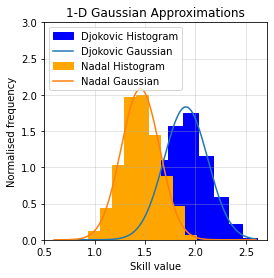

In [37]:
from scipy.stats import norm

fig, ax = plt.subplots(1, figsize = (4,4))
def plot_hist_with_overlay(values, player, color):
    x = np.linspace(0.6, 2.6, 1000)
    (mu, sigma) = norm.fit(values)
    print("{} has mu={}, sigma={}".format(player, mu, sigma))

    fit = norm.pdf(x, mu, sigma)

    plt.hist(
        values,
        density=True,
        label=player[0].split("-")[1] + " Histogram",
        edgecolor=color,
        fill=True,
        color=color,
    )
    plt.plot(x, fit, label=player[0].split("-")[1] + " Gaussian")


plot_hist_with_overlay(djokovic_samples, W[djokovic], "blue")
plot_hist_with_overlay(nadal_samples, W[nadal], "orange")
plt.title("1-D Gaussian Approximations")
plt.grid(alpha = 0.4)
plt.xlabel("Skill value")
plt.ylim((0,3))
plt.ylabel("Normalised frequency")
plt.legend(loc="upper left")
plt.savefig('plots/taskd_1.png', format='png', dpi=500, bbox_inches='tight')

#### Calculate marginal Gaussians

In [24]:
marginal_skill_means = np.mean(skill_samples_burned_in[[15, 0], :], axis=1)
marginal_skill_vars = np.var(skill_samples_burned_in[[15, 0], :], axis=1)
print(marginal_skill_means, marginal_skill_vars)

[1.9050606  1.45369315] [0.04735179 0.0366188 ]


In [25]:
# Probability Djokovic's skill is higher
prob_skill_higher = 1.0 - norm.cdf(
    0,
    marginal_skill_means[0] - marginal_skill_means[1],
    (marginal_skill_vars.sum()) ** 0.5,
)
print(prob_skill_higher)

0.9403404981515663


#### Calcualate Joint Gaussians

In [26]:
mean = np.mean(skill_samples_burned_in[[15, 0], :], axis=1)
cov = np.cov(skill_samples_burned_in[[15, 0], :], rowvar=1)
print(cov)

[[0.04739527 0.00738138]
 [0.00738138 0.03665243]]


In [27]:
mc_joint_gaussian_samples = np.random.multivariate_normal(mean, cov, size=100000)
prob_skill_higher = np.mean(
    mc_joint_gaussian_samples[:, 0] > mc_joint_gaussian_samples[:, 1]
)
print(prob_skill_higher)

0.95636


[1.4536931508058337, 1.9050606005227544]
[[0.03665243 0.00738138]
 [0.00738138 0.04739527]]
 & a & a \\ \midrule 
a & \num{0.0367} & \num{0.0074}\\ 
a & \num{0.0074} & \num{0.0474}\\ 



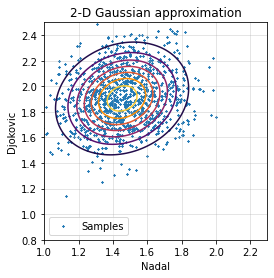

In [55]:
from scipy.stats import multivariate_normal

# nadal_samples = skill_samples[10, indices] # switch to Murray

mean_vector = [np.mean(nadal_samples), np.mean(djokovic_samples)]
cov_matrix = np.cov(nadal_samples, djokovic_samples)

print(mean_vector)
print(cov_matrix)
print(numpy_to_latex(cov_matrix, ["a", "a"], ["a", "a"]))

lower = 1
upper = 2.5
x, y = np.mgrid[lower:upper:0.01, lower:upper:0.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean=mean_vector, cov=cov_matrix)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
cs = ax.contour(x, y, rv.pdf(pos), cmap="inferno")
ax.scatter(nadal_samples, djokovic_samples, marker="x", s=2, label="Samples")
plt.xlim(lower, upper-0.2)
plt.ylim(lower-0.2, upper)
plt.legend()
ax.grid(alpha=0.4)
plt.xlabel("Nadal")
plt.ylabel("Djokovic")
plt.title("2-D Gaussian approximation")
plt.savefig("plots/taskd_2.png", format="png", dpi=500, bbox_inches="tight")

#### Calculate directly from Gibbs samples (Djokovic vs Nadal)

Diff has mu=0.4513674497169203, sigma=0.26309955564776977


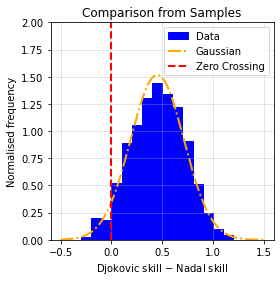

In [54]:
values = djokovic_samples - nadal_samples

bins = np.linspace(-0.5, 1.5, 21)
x = np.linspace(-0.5, 1.5, 1000)


(mu, sigma) = norm.fit(values)
print("Diff has mu={}, sigma={}".format(mu, sigma))
fit = norm.pdf(x, mu, sigma)

fig = plt.figure(figsize=(4, 4))
_, _, bars = plt.hist(
    values, bins=bins, density=True, edgecolor="blue", color="blue", label="Data"
)
plt.plot(x, fit, linestyle="-.", linewidth=2, label="Gaussian", color="orange")
plt.axvline(x=0, linestyle="--", linewidth=2, color="red", label="Zero Crossing")

# for bar in bars:
#     if bar.get_x() < 0:
#         bar.set_facecolor("orange")
#         bar.set_edgecolor("orange")
plt.grid(alpha=0.4)
plt.title("Comparison from Samples")
plt.xlabel("Djokovic skill $-$ Nadal skill")
plt.ylabel("Normalised frequency")
plt.ylim((0, 2))
plt.legend(loc="upper right")

plt.savefig("plots/taskd_3.png", format="png", dpi=500, bbox_inches="tight")

In [29]:
prob_skill_higher = np.mean(
    skill_samples_burned_in[15, :] > skill_samples_burned_in[0, :]
)
print(prob_skill_higher)

0.9587155963302753


#### Calculate from Gibbs for 4 top players

In [45]:
prob_higher_skill = np.zeros([4, 4])
for i in range(4):
    for j in range(4):
        player1 = top_4_atp_ids[i]
        player2 = top_4_atp_ids[j]
        prob_higher_skill[i, j] = np.mean(
            skill_samples_burned_in[player1, :] > skill_samples_burned_in[player2, :]
        )
print(np.array(prob_higher_skill))

[[0.         0.9587156  0.9266055  0.98899083]
 [0.0412844  0.         0.37247706 0.72844037]
 [0.0733945  0.62752294 0.         0.80458716]
 [0.01100917 0.27155963 0.19541284 0.        ]]


In [61]:
from scipy.stats import norm

# top_four = [15, 4, 0, 10]
top_four = top_4_atp_ids
burn_in = 10
num_iters = 1100


indices = np.array(range(burn_in, num_iters))

selected_samples = np.zeros((4, len(indices)))

for idx, p in enumerate(top_four):
    selected_samples[idx] = skill_samples[p, indices]

prob_better_player = np.zeros((4, 4))
print(W[top_four])
for i in range(0, 4):
    for j in range(0, 4):
        skill_diff = np.mean(selected_samples[i] - selected_samples[j])
        var = np.sum(np.cov(selected_samples[i], -selected_samples[j]))
        prob_better_player[i, j] = norm.cdf(skill_diff / np.sqrt(var))

print(prob_better_player)
print(numpy_to_latex(prob_better_player, top_4_atp, top_4_atp))

[['Novak-Djokovic']
 ['Rafael-Nadal']
 ['Roger-Federer']
 ['Andy-Murray']]
[[       nan 0.95680809 0.92235253 0.98211676]
 [0.04319191        nan 0.37721428 0.73613053]
 [0.07764747 0.62278572        nan 0.80084385]
 [0.01788324 0.26386947 0.19915615        nan]]
 & Novak-Djokovic & Rafael-Nadal & Roger-Federer & Andy-Murray \\ \midrule 
Novak-Djokovic & nan & 0.9568 & 0.9224 & 0.9821\\ 
Rafael-Nadal & 0.0432 & nan & 0.3772 & 0.7361\\ 
Roger-Federer & 0.0776 & 0.6228 & nan & 0.8008\\ 
Andy-Murray & 0.0179 & 0.2639 & 0.1992 & nan\\ 



<ipython-input-61-23b2d5b9aa55>:22: RuntimeWarning: invalid value encountered in scalar divide
  prob_better_player[i, j] = norm.cdf(skill_diff / np.sqrt(var))


In [68]:
for i in range(4):
    prob_better_player[i, i] = 0.5
print(prob_better_player)
print(prob_has_better_skill)
test = prob_better_player - prob_has_better_skill
print(numpy_to_latex(test, top_4_atp, top_4_atp))

[[0.5        0.95680809 0.92235253 0.98211676]
 [0.04319191 0.5        0.37721428 0.73613053]
 [0.07764747 0.62278572 0.5        0.80084385]
 [0.01788324 0.26386947 0.19915615 0.5       ]]
[[0.5        0.93982214 0.90888525 0.9853215 ]
 [0.06017786 0.5        0.42717033 0.76651864]
 [0.09111475 0.57282967 0.5        0.81083534]
 [0.0146785  0.23348136 0.18916466 0.5       ]]
 & Novak-Djokovic & Rafael-Nadal & Roger-Federer & Andy-Murray \\ \midrule 
Novak-Djokovic & 0.0000 & 0.0170 & 0.0135 & -0.0032\\ 
Rafael-Nadal & -0.0170 & 0.0000 & -0.0500 & -0.0304\\ 
Roger-Federer & -0.0135 & 0.0500 & 0.0000 & -0.0100\\ 
Andy-Murray & 0.0032 & 0.0304 & 0.0100 & 0.0000\\ 



## Player rankings

In [69]:
skill_mean_gibbs = np.mean(skill_samples_burned_in, axis=1)
skill_std_gibbs = np.std(skill_samples_burned_in, axis=1)
skill_mean_mp = mean_player_skills
skill_std_mp = (1 / precision_player_skills) ** 0.5

In [73]:
def sorted_rangeplot(mean, std_dev, W, label_x="", title_x=""):
    label = str(label_x)
    print(type(label_x))
    M = len(mean)
    xx = np.linspace(0, M, M)
    plt.figure(figsize=(20, 20))
    sorted_indices = np.argsort(mean)
    sorted_names = W[sorted_indices]
    plt.barh(xx, std_dev[sorted_indices], left=mean[sorted_indices])
    plt.yticks(np.linspace(0, M, M), labels=sorted_names[:, 0])
    plt.ylim([-2, 109])
    plt.xlabel(label)
    plt.title(title_x)
    # plt.show()

<class 'str'>


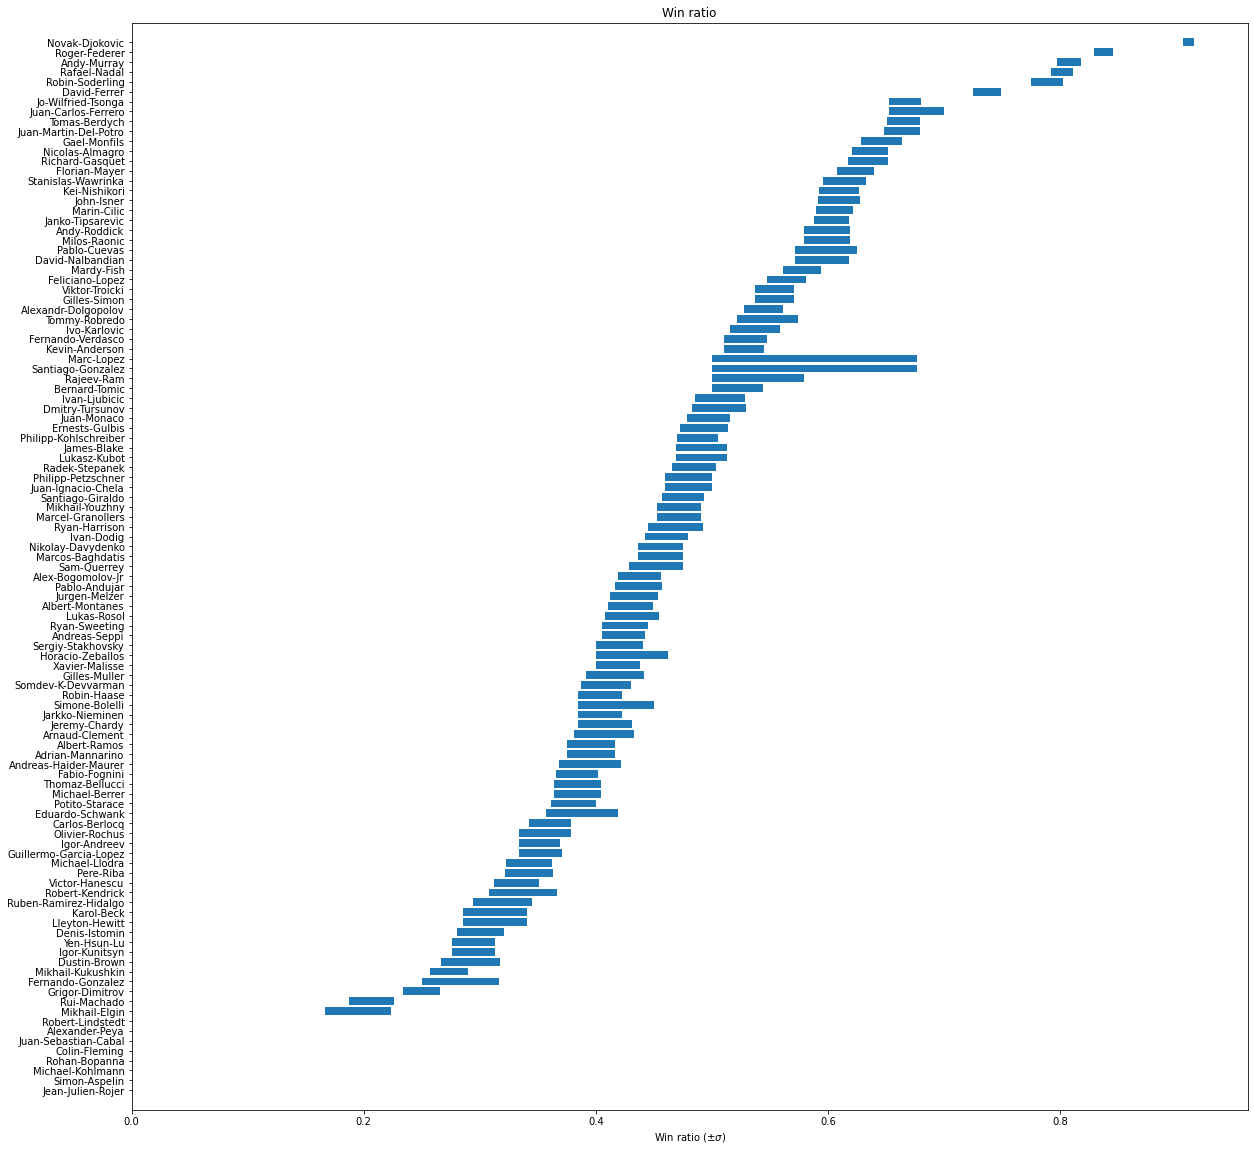

In [74]:
# empirical outcomes
points = np.zeros(M)
matches = np.zeros(M)

for p in range(0, M):
    for g in range(0, N):
        if G[g, 0] == p:
            points[p] += 1
            matches[p] += 1
        elif G[g, 1] == p:
            matches[p] += 1
            

win_ratio = np.true_divide(points, matches)
var = np.multiply(win_ratio, 1 - win_ratio)
win_std = np.true_divide(var, np.sqrt(matches))
sorted_rangeplot(
    win_ratio, win_std, W, label_x="Win ratio ($\pm \sigma$)", title_x="Win ratio"
)

<class 'str'>


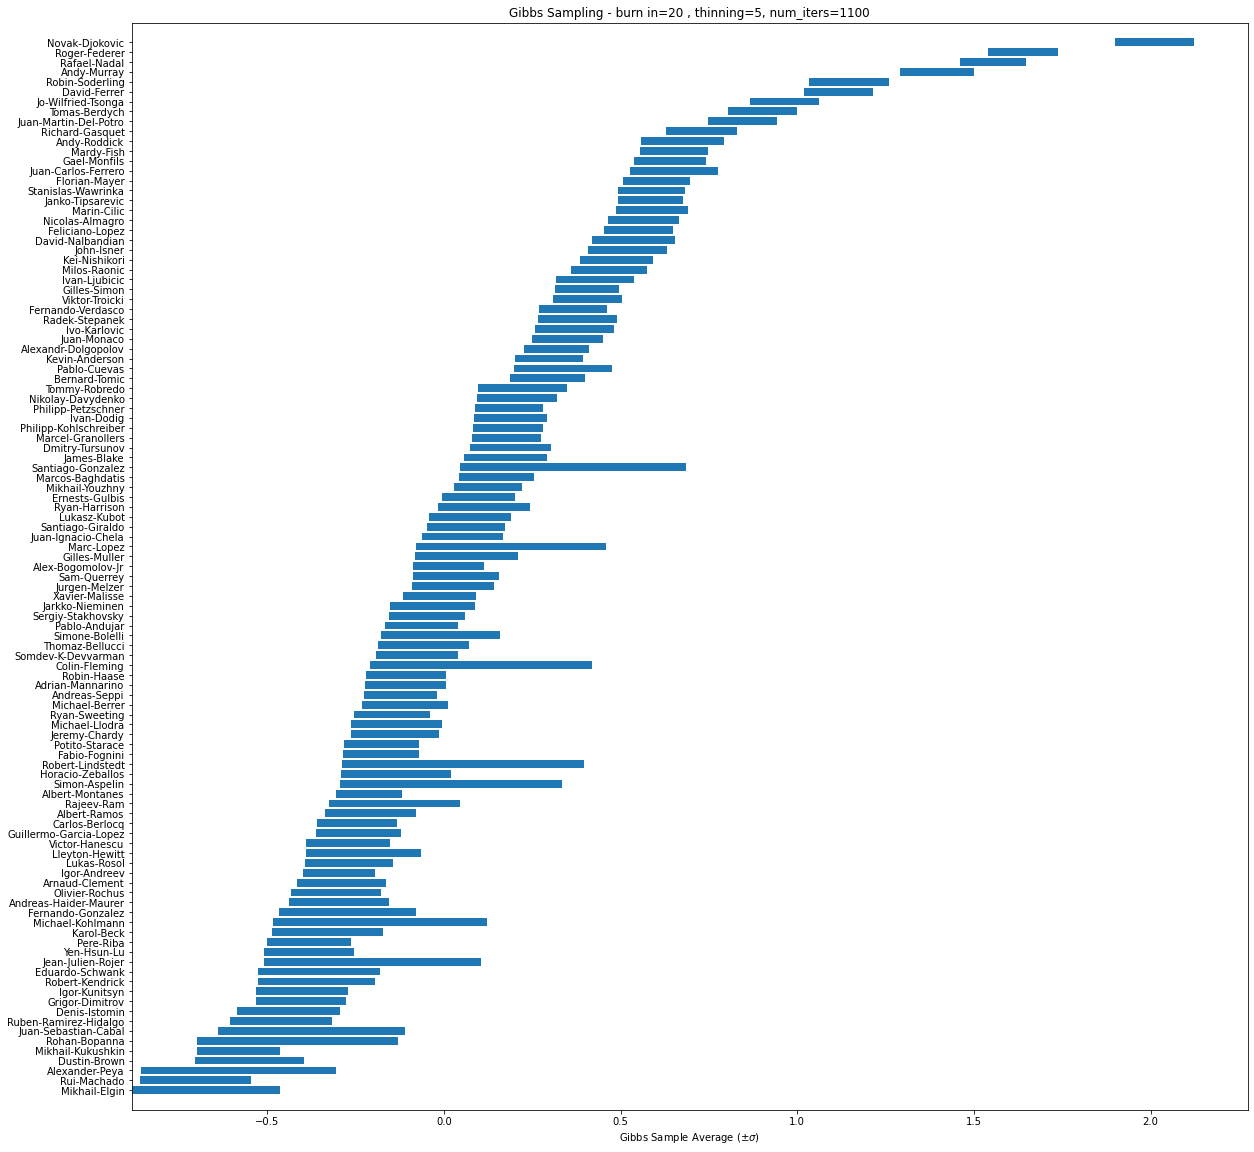

In [75]:
# predictions based on gibbs

burn_in = 20
thinning = 5
num_iters = 1100

indices = np.array(range(burn_in, num_iters, thinning))
relevant_samples = skill_samples[:, indices]

gibbs_means = np.mean(relevant_samples, axis=1)
gibbs_std = np.std(relevant_samples, axis=1)

sorted_rangeplot(
    gibbs_means,
    gibbs_std,
    W,
    label_x = "Gibbs Sample Average ($\pm \sigma$)",
    title_x = f"Gibbs Sampling - burn in={burn_in} , thinning={thinning}, num_iters={num_iters}"
)

<class 'str'>


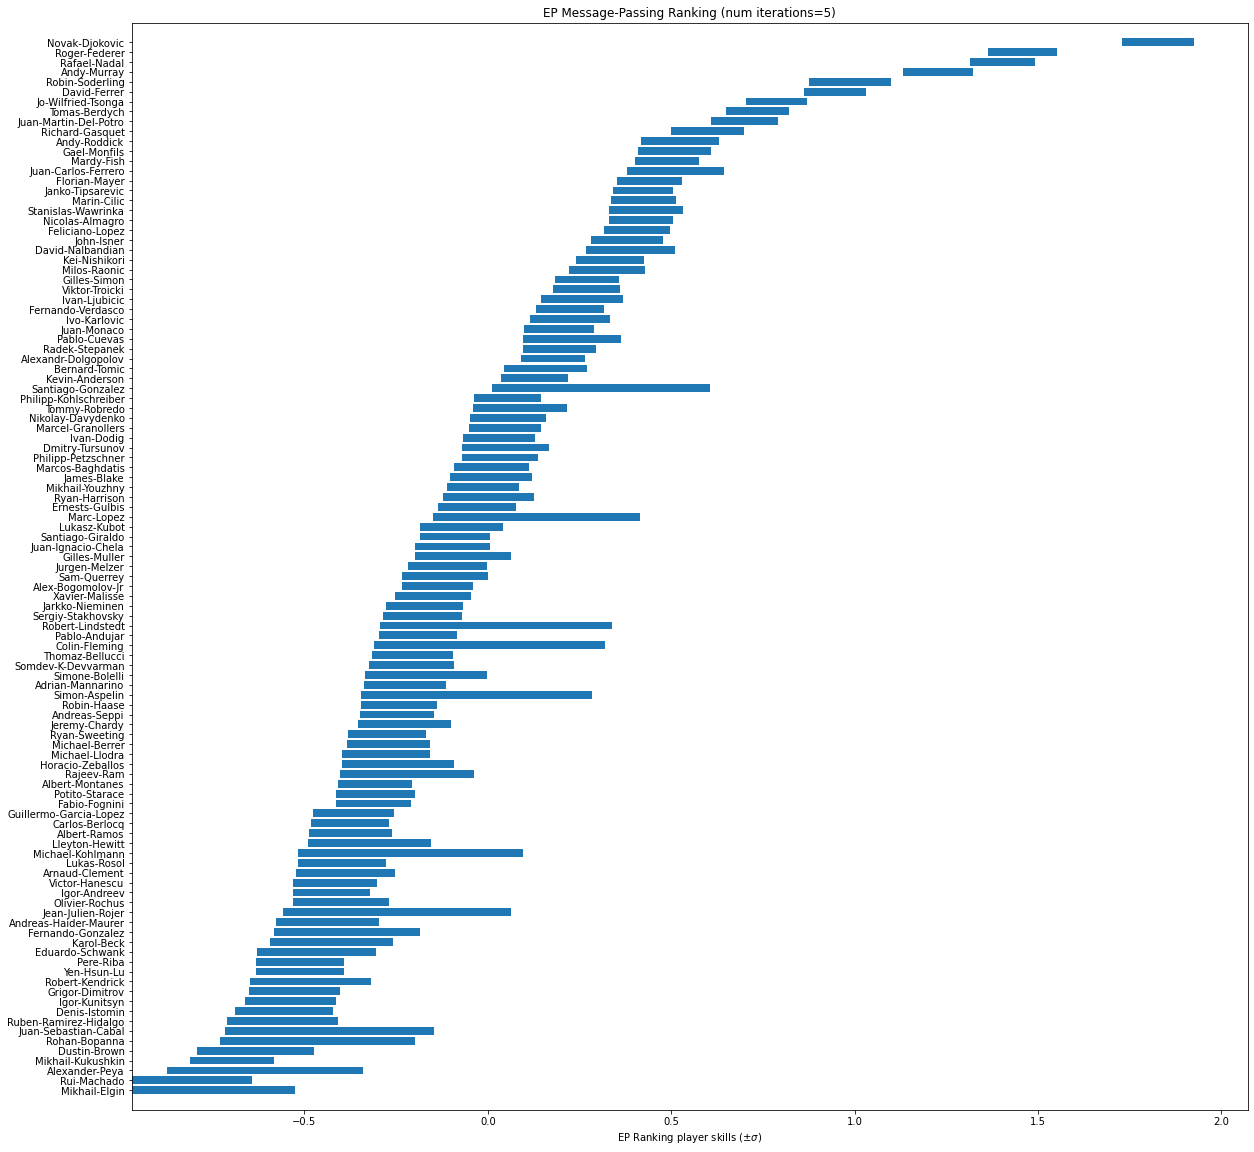

In [76]:
# Message Passing
num_iters = 5
# run message passing algorithm, returns mean and precision for each player
ep_means, precision_player_skills = eprank_non_iter(G, M, num_iters)

ep_std = np.sqrt(np.true_divide(1, precision_player_skills))
sorted_rangeplot(
    ep_means,
    ep_std,
    W,
    label_x="EP Ranking player skills ($\pm \sigma$)",
    title_x="EP Message-Passing Ranking (num iterations={})".format(num_iters),
)

In [77]:
from scipy.stats import spearmanr

win_rankings = np.argsort(win_ratio)
gibbs_rankings = np.argsort(gibbs_means)
ep_rankings = np.argsort(ep_means)

print(gibbs_rankings)
print(ep_rankings)

print(spearmanr(win_rankings, gibbs_rankings))
print(spearmanr(win_rankings, ep_rankings))
print(spearmanr(ep_rankings, gibbs_rankings))

[104  74  96  88  51 101  97  85  66  53  67  87  58 106  80  84  38 102
  82  91  36  93  77  94  70  55   6  50  72  95  90 103  56 105  43  73
  92  27  18  83  48  60  59  98  34  89  49  21  54  30  75  76  63  81
  13 100  78   9  86  71  39  52  26  99  65  61  45  68  17  64  40  69
  37  57  62  32   1  35  19  16  79  41  22   8  31  20  12  24  42  25
  47  46   7  44  28   3  14  11   2  33   5  29  23  10   0   4  15]
[104  74  96  51  88 101  97  85  66  67  53  87  80  84  58  38  82  91
 106  36  77  55  93  94 102  70  72  50   6  43  73  90  95  56  27  83
  18  92  48  59 103  60  49  34  89  98  21 105  54  30  75  81  63  76
  13  78   9  86 100  39  71  52  65  26  64  61  17  45  40  69  68  99
  62  37  32  19  57   1  35  16  22  79  41   8  31  12  20  24  42  46
  25  47   7  44   3  28  14  11   2  33   5  29  23  10   0   4  15]
SignificanceResult(statistic=0.5394992064891554, pvalue=2.0227872456334692e-09)
SignificanceResult(statistic=0.42723211661670485, 

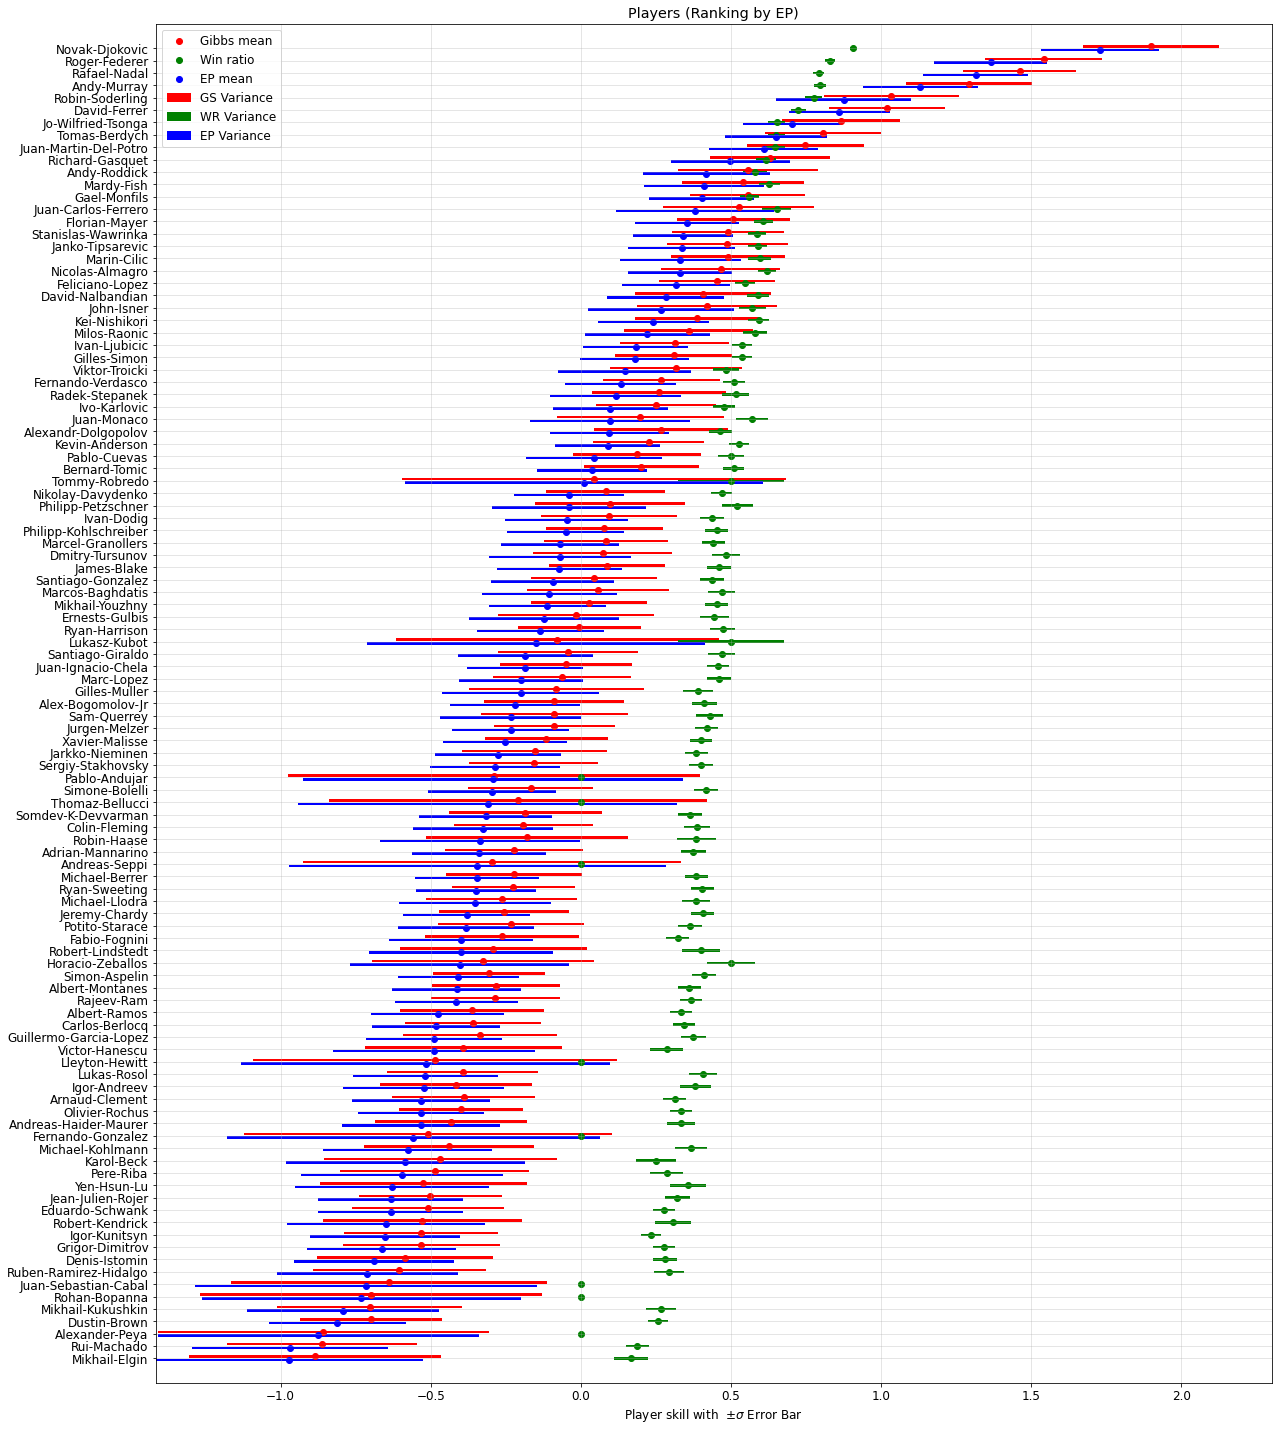

In [89]:
mean = mean_player_skills
std_dev = std_dev
import matplotlib

matplotlib.rcParams.update({"font.size": 12})

M = len(mean)
xx = np.linspace(0, M, M)
plt.figure(figsize=(20, 25))
gibbs_rankings = np.argsort(gibbs_means)
ep_rankings = np.argsort(ep_means)
sorted_names = W[gibbs_rankings]

plt.barh(
    xx + 0.15,
    height=0.2,
    width=2 * gibbs_std[ep_rankings],
    left=gibbs_means[ep_rankings] - gibbs_std[ep_rankings],
    label="GS Variance",
    color="r",
)
plt.barh(
    xx,
    height=0.2,
    width=2 * win_std[ep_rankings],
    left=win_ratio[ep_rankings] - win_std[ep_rankings],
    label="WR Variance",
    color="g",
)
plt.barh(
    xx - 0.15,
    height=0.2,
    width=2 * ep_std[ep_rankings],
    left=ep_means[ep_rankings] - ep_std[ep_rankings],
    label="EP Variance",
    color="b",
)

plt.scatter(
    gibbs_means[ep_rankings], xx + 0.15, marker="o", label="Gibbs mean", color="r"
)
plt.scatter(win_ratio[ep_rankings], xx, marker="o", label="Win ratio", color="g")
plt.scatter(ep_means[ep_rankings], xx - 0.15, marker="o", label="EP mean", color="b")


plt.yticks(xx, labels=sorted_names[:, 0])
plt.ylim([-2, 109])
plt.xlabel("Player skill with  $\pm\sigma$ Error Bar")
plt.title("Players (Ranking by EP)")
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("plots/taske.png", format="png", dpi=500, bbox_inches="tight")